In [23]:
# This notebook is for debugging general functions (from utils.py) for example.

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.PonderCAModel import PonderCAModel
from lib.AdaptiveFireRateCAModel import AdaptiveFireRateCAModel
from lib.EnergyCAModel import EnergyCAModel

from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks, damage_batch
from lib.utils import *
from lib.losses import ReconstructionLoss, RegularizationLoss, ReconstructionLoss_AdaptFireRate, RegularizationLoss_AdaptFireRate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


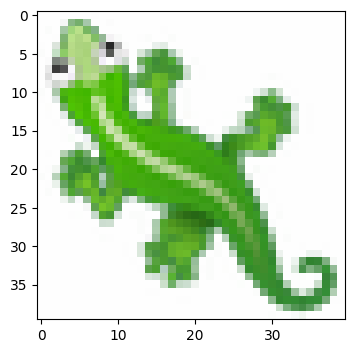

In [10]:
# params
device = torch.device("cpu")
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999 ###currently not used
betas = (0.5, 0.5)
n_epoch = 8000

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 0 #@param "🦎"
EMOJI_NAME = "Lizard"
EXPERIMENT_TYPE = "Growing"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


## PonderNet and AdaptiveFireRateCA Params ##
IMG_SIZE = 72       # final padded image side length
LAMBDA_P = 1/3      # reasonable 1/expected_steps (interpretation for PonderCA)
                     
MAX_STEPS = 100
BETA = 0.01         # regularization param

## EnergyCA Params ##
BETA_ENERGY = 1e-6
MIN_FIRERATE = 0.01
MAX_FIRERATE = 0.8


target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.show()


In [17]:
# Create pad_target
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))
debug("pad_target.shape")


pad_target.shape = torch.Size([1, 72, 72, 4])


In [21]:
# Create a batch by expanding dim=0 to BATCH_SIZE
batch = pad_target.repeat(BATCH_SIZE, 1, 1, 1)

# expand the channels in the last dimension to CHANNEL_N
batch = batch.repeat(1, 1, 1, 4)

debug("batch.shape")

batch.shape = torch.Size([8, 72, 72, 16])


## Debugging utils_vis.py

In [30]:
# Test functionality of damage_batch
batch = damage_batch(batch, img_size = IMG_SIZE, damage_location="random" , damaged_in_batch = 1)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(batch[0]))
plt.show()


NameError: name 'self' is not defined